# Custom GP modeling for BO

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from xopt.vocs import VOCS

my_vocs = VOCS(
    variables = {"x":[-1,3]},
    objectives = {"y":"MAXIMIZE"},
)


In [2]:
# define test functions

test_x = torch.linspace(*torch.tensor(my_vocs.bounds.flatten())*3, 100)

# define training data to pass to the generator
train_x = torch.tensor((0.0, 0.75))
train_y = train_x

training_data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy()}
)

## Custom prior mean function
Here we assume we have some knowledge of the ground truth function, which we can take
 advantage of to speed up optimization. This "prior mean" function is specified by a
 pytorch module. Notice how away from the training data, the GP model reverts to the
 prior mean.

In [3]:
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator
from xopt.generators.bayesian.options import ModelOptions
from xopt.generators.bayesian.expected_improvement import BayesianOptions

class SquaredPrior(torch.nn.Module):
    def forward(self, X):
        return 3*torch.sin(X.squeeze(dim=-1) + 0.25)

model_options = ModelOptions(
    mean_modules={"y":SquaredPrior()},
)
generator_options = BayesianOptions(model=model_options)
generator = ExpectedImprovementGenerator(my_vocs, options=generator_options)
generator.add_data(training_data)

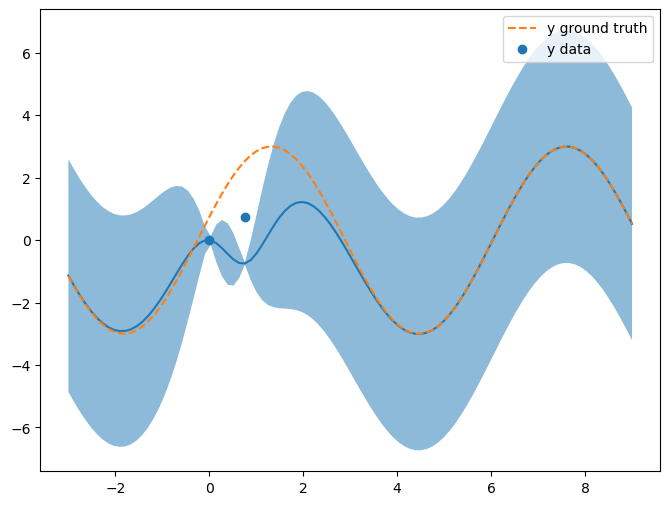

In [4]:
# view custom model from data
model = generator.train_model()


fig,ax = plt.subplots(1,1, sharex="all")
fig.set_size_inches(8,6)
with torch.no_grad():
    post = model.posterior(test_x.reshape(-1,1,1).double())

    mean = post.mean.squeeze()
    l,u = post.mvn.confidence_region()
    ax.plot(test_x, mean)
    ax.fill_between(test_x, l.squeeze(), u.squeeze(), alpha=0.5)

    # plot prior
    ax.plot(test_x, SquaredPrior()(test_x),'C1--', label="y ground truth")

    # plot training data
    ax.plot(train_x, train_y,"C0o", label="y data")
    ax.legend()


In [12]:
model.models[0].train_targets.shape

torch.Size([2])

In [6]:
list(model.named_parameters())

[('models.0.likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-15.9679], dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.raw_outputscale',
  Parameter containing:
  tensor(12.3509, dtype=torch.float64, requires_grad=True)),
 ('models.0.covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-1.4515]], dtype=torch.float64, requires_grad=True))]